# Network construction

In [1]:
import csv
import pandas as pd
from collections import Counter
from itertools import permutations
from itertools import combinations
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx
import numpy as np
import powerlaw

In [2]:
file_movies = 'title.basics.tsv/title.basics.tsv'
movies = pd.read_csv(file_movies, sep='\t', na_values='\\N', dtype={
    'tconst': 'str',
    'titleType': 'str',
    'primaryTitle': 'str',
    'startYear': 'Int64',
}, usecols=['tconst', 'titleType', 'primaryTitle', 'startYear']).set_index('tconst')

In [3]:
movies = movies[(movies['startYear'] >= 1973) & (movies['titleType'] == 'movie')]
del movies['titleType']

In [4]:
file_akas = 'title.akas.tsv/title.akas.tsv'
akas_data = pd.read_csv(file_akas, sep='\t', na_values='\\N', dtype={
    'titleId': 'str',
    'ordering': 'int',
    'title': 'str',
    'region': 'str',
    'language': 'str',
    'types': 'str',
    'attributes': 'str',
})

In [5]:
file_cast = 'title.principals.tsv/title.principal.tsv'
cast = pd.read_csv(file_cast, sep='\t', na_values='\\N', dtype={
    'tconst': 'str',
    'nconst': 'str',
    'category': 'str',
}, usecols=['tconst', 'nconst', 'category'])

In [6]:
cast = cast[cast.category.isin({'actor', 'actress'}) & cast['tconst'].isin(movies.index)]
cast.reset_index(drop=True, inplace=True)

In [7]:
#we create a bipartite network:
B = nx.Graph()

actors = cast['nconst'].unique()
movies = movies.index.unique()

B.add_nodes_from(actors, bipartite=0)  # Actors belong to set 0
B.add_nodes_from(movies, bipartite=1)  # Movies belong to set 1


for _, row in cast.iterrows():
    actor = row['nconst']
    movie = row['tconst']
    B.add_edge(actor, movie)

In [8]:
act=bipartite.projected_graph(B,actors)
nx.is_connected(act)

False

In [9]:
largest_cc = max(nx.connected_components(act), key=len)

In [10]:
A = act.subgraph(largest_cc)

In [11]:
A.number_of_nodes()

432920

In [12]:
A.number_of_edges()

2103908

# Power  Law

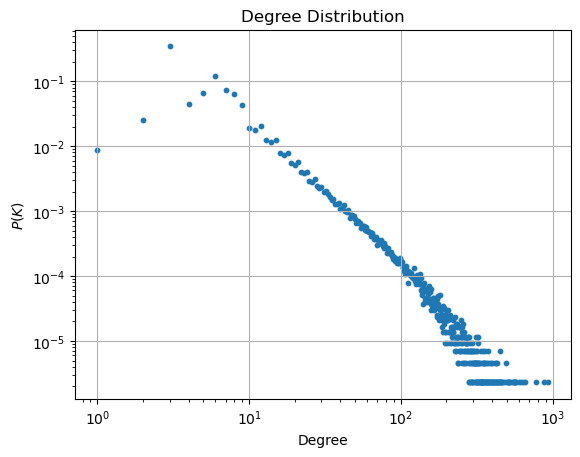

In [13]:
# Calculate the degree distribution
degree_sequence = [d for n, d in A.degree()]
total_nodes = len(A.nodes())

# Calculate the unique degrees and their counts
unique_degrees, degree_counts = np.unique(degree_sequence, return_counts=True)

# Calculate frequencies by dividing degree counts by total nodes
frequencies = degree_counts / total_nodes

# Create a semi-logarithmic scatter plot
plt.scatter(unique_degrees, frequencies, marker='o', s=10)
plt.xlabel('Degree')
plt.ylabel('$P(K)$')
plt.yscale('log') 
plt.xscale('log') 
plt.title('Degree Distribution')
plt.grid(True)
plt.show()

In [14]:
import powerlaw as pwl

fit_function = pwl.Fit(degree_sequence)

Calculating best minimal value for power law fit


In [15]:
fit_function.power_law.alpha

2.403953169428489

In [16]:
fit_function.power_law.sigma

0.004875307642959534

Text(0, 0.5, '$P(k)$')

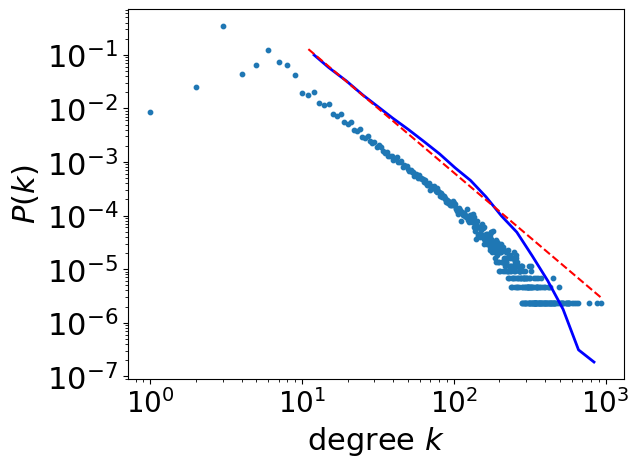

In [17]:
plt.scatter(unique_degrees, frequencies, marker='o', s=10)

fig = fit_function.plot_pdf(color='b', linewidth=2)
fit_function.power_law.plot_pdf(color='r', linestyle='--', ax=fig)

plt.xticks(fontsize=20)
plt.yticks(fontsize=22)

plt.yscale('log')
plt.xscale('log')

#add legenda
plt.xlabel('degree $k$', fontsize=22)
plt.ylabel('$P(k)$', fontsize=22)

Calculating best minimal value for power law fit


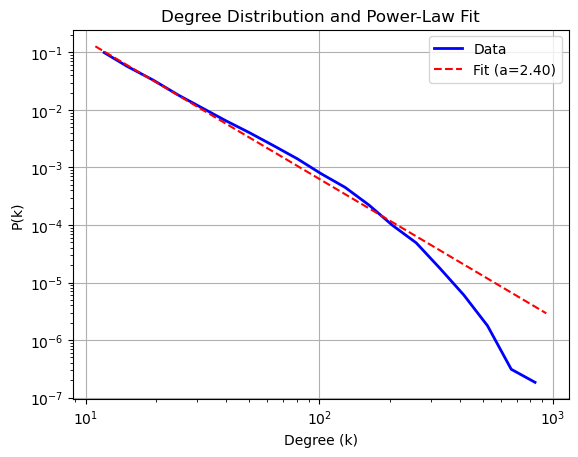

Estimated exponent 'a': 2.40


In [18]:
# Compute the degree of each node and store it in a list
degree_sequence = [d for n, d in A.degree()]

# Create a powerlaw distribution object
fit = powerlaw.Fit(degree_sequence)

# Plot the degree distribution and the power-law fit
fig = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig)

# Extract the estimated exponent 'a' from the fit
estimated_exponent = fit.power_law.alpha

plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.title('Degree Distribution and Power-Law Fit')
plt.grid(True)

plt.legend(['Data', f'Fit (a={estimated_exponent:.2f})'])

plt.show()

print(f"Estimated exponent 'a': {estimated_exponent:.2f}")


# Barabàsi-Albert model comparison

In [19]:
nodes=A.number_of_nodes()
edges_per_node=int(A.number_of_edges()/nodes)

In [20]:
BA = nx.barabasi_albert_graph(nodes,edges_per_node)

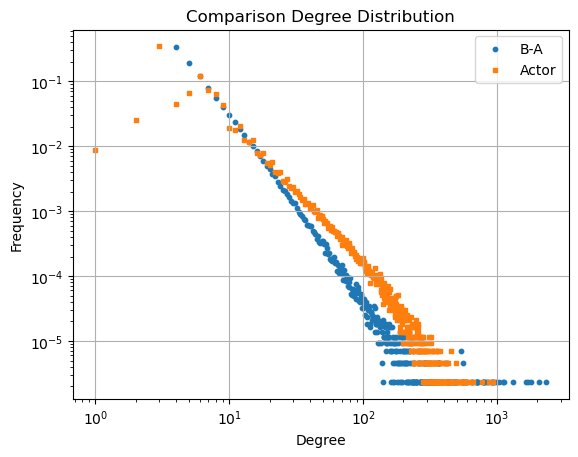

In [27]:
# Calculate the degree distribution
degree_sequence_ba = [d for n, d in BA.degree()]
total_nodes_ba = len(BA.nodes())

# Calculate the unique degrees and their counts
unique_degrees_ba, degree_counts_ba = np.unique(degree_sequence_ba, return_counts=True)

# Calculate frequencies by dividing degree counts by total nodes
frequencies_ba = degree_counts_ba / total_nodes

plt.scatter(unique_degrees_ba, frequencies_ba, marker='o', s=10)
plt.scatter(unique_degrees, frequencies, marker='s', s=10)
plt.legend(['B-A', 'Actor'])
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.yscale('log') 
plt.xscale('log') 
plt.title('Comparison Degree Distribution')
plt.grid(True)
plt.show()

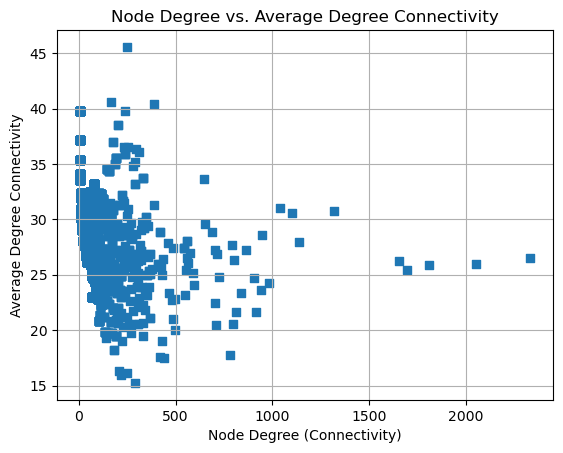

In [22]:
# Calculate the degree of each node
node_degrees = dict(BA.degree())

# Calculate the average degree connectivity
average_degree_connectivity = nx.average_degree_connectivity(BA)

# Extract the degrees and corresponding average degree connectivity
degrees = list(node_degrees.values())
avg_deg_connectivity = [average_degree_connectivity[deg] for deg in degrees]

# Plot the connectivity (degree) of each node vs. average degree connectivity
plt.scatter(degrees, avg_deg_connectivity, marker='s')
plt.xlabel("Node Degree (Connectivity)")
plt.ylabel("Average Degree Connectivity")
plt.title("Node Degree vs. Average Degree Connectivity")
plt.grid(True)
plt.show()


In [25]:
nx.average_clustering(BA)

0.0003023645273213209

In [26]:
nx.degree_assortativity_coefficient(BA)

-0.010064665369776609